In [1]:
from model import Network
from data import load_cifar10_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
# load to model
model_config = './model_config/fc2_cocktail_party_instance_wout_bias.json'
checkpoint_path = './checkpoints/122123_fc2_cocktail_party_cifar10_pretraining_wout_bias_without_normalization.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# get val loader
batch_size = 4
data_path = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
])

_, val_dataloader = load_cifar10_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([256, 3072]), torch.Size([10, 256])]


In [4]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [5]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(32, 32, 3, 1, 5, 5)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 2.082310676574707
loss: 0.001529045170173049
loss: 0.00023878284264355898
loss: 0.00020618819689843804
loss: 0.00020170585776213557
loss: 0.0001958848733920604
loss: 0.00019439020252320915
loss: 0.00019632588373497128
loss: 0.00019582956156227738
loss: 0.0001963956601684913
loss: 0.00019656271615531296
loss: 0.00019693319336511195
loss: 0.00019658416567835957
loss: 0.00019687938038259745
loss: 0.00019630037422757596
loss: 0.00019600540690589696
loss: 0.0001964969706023112
loss: 0.0001962774695130065
loss: 0.00019553066522348672
loss: 0.0001959783985512331
loss: 0.0001955650805030018
loss: 0.00019596716447267681
loss: 0.00019668355525936931
loss: 0.00019639977836050093
loss: 0.0001965912088053301
loss: 0.00019585744303185493


## Estimated images

tensor([[ 1.4448e-05,  9.9142e-06,  5.6874e-06,  ..., -2.0447e-05,
         -2.3813e-05, -2.3541e-05],
        [ 2.1277e-05,  6.6250e-06,  9.0951e-06,  ..., -3.0205e-05,
         -2.4617e-05, -2.6145e-05],
        [ 2.0125e-05,  6.3300e-06,  9.2006e-06,  ..., -3.0522e-05,
         -2.5232e-05, -2.6955e-05],
        [ 2.1348e-05,  7.1563e-06,  9.6165e-06,  ..., -3.0208e-05,
         -2.4972e-05, -2.6495e-05]])


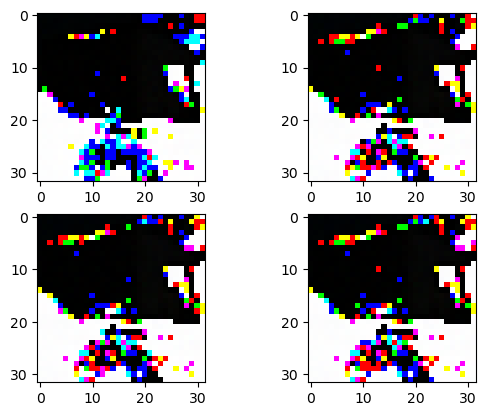

In [8]:
with torch.no_grad():
    unmixing_matrix = unmixing_matrix.detach().to('cpu')
    whitened_gradient = whitened_gradient.detach().to('cpu')
    estimated_img = unmixing_matrix @ whitened_gradient
    print(estimated_img)
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(estimated_img, axes.flatten()):
        img = transforms.ToPILImage()(torch.clamp(estimate.reshape(3, 32, 32), min=-1, max=1) * 400)
        img = np.asarray(img)
        ax.imshow(img)
    plt.show()

## Original images

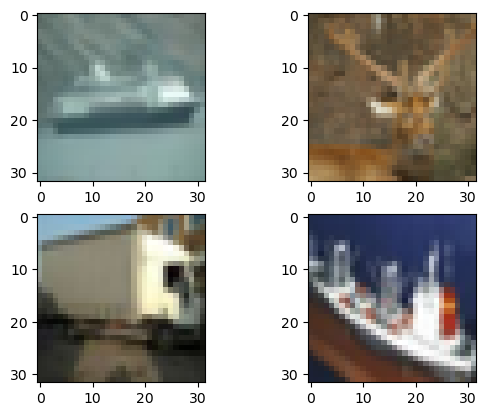

In [9]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(torch.clamp(estimate.reshape(3, 32, 32), min=-1, max=1))
        img = np.asarray(img)
        ax.imshow(img)
    plt.show()